## Final Project Submission

Please fill out:
* Student name: Zeth Abney
* Student pace: Flex (40 week)
* Scheduled project review date/time: 04/20/2022 9:00 AM
* Instructor name: Matt Bombard
* Blog post URL: !!!TBA!!!

# Overview
![img](./media/house_flip.png)

The data set used in this analysis is open-source data available directly from Kings County's website (https://kingcounty.gov/services/data.aspx). This particular data set covers various aspects of realestate transactions including date of sale, square footage of house and lot, proximity to recreational and natural resources, etc. 

The initial data set used contains 21597 total records, aproximately 7% of which is eventually thrown out as a result of either data cleaning or model fitting. The dataset starts with 20 total features (i.e. columns), only 8 of which are ultimately included in the final model aslo with 6 additional features inferred from the original data (e.g. one-hot encoding).

For the purposes of regression modeling the data is manipulated so that every datapoint is encoded as either and integer or a decimal and there are no null or missing values. Also, the target variable 'price' is eventually log-transomed as part of the modelfitting process; keep in mind that because of the log-transformation the model coefficients should be interpreted as the percentages rather than the metric's own units. This is explained further in the regrssion results section of this notebook. 

For more details on understanding the data and statistics of the final model see the [model data dictionary](model_dictionary.md)

# The Business Problem

FlipHouse, LLC. Is a  profesional 'house flipping' business seeking to enter the realestate market of the pacific northwest, and specifically Seattle Washington and the surrounding area (i.e. Kings County). Before begining any projects in the area, FlipHouse decision makers need to better understand the how to determine the opportunity cost, and potential returns for any investments made in Kings County, as well as how to maximize those returns. The oportunity cost and potential returns can indeed be determined by understanding how time, physical location, and physical condition and attributes all affect the price of a real estate property. 

Therefore, this anaylisis will seek to build a statistical model that is informative as far as specifiying what metrics to use and how strong each metric may be in terms of predicting the market value of a real estate property. 

# Understanding the data
![img](./media/data_understanding.png)

The data set used in this analysis is open-source data available directly from Kings County's website (https://kingcounty.gov/services/data.aspx). This particular data set covers various aspects of realestate transactions including date of sale, square footage of house and lot, proximity to recreational and natural resources, etc. 

The initial data set used contains 21597 total records, aproximately 7% of which is eventually thrown out as a result of either data cleaning or model fitting. The dataset starts with 20 total features (i.e. columns), only 8 of which are ultimately included in the final model aslo with 6 additional features inferred from the original data (e.g. one-hot encoding).

For the purposes of regression modeling the data is manipulated so that every datapoint is encoded as either and integer or a decimal and there are no null or missing values. Also, the target variable 'price' is eventually log-transomed as part of the modelfitting process; keep in mind that because of the log-transformation the model coefficients should be interpreted as the percentages rather than the metric's own units. This is explained further in the regrssion results section of this notebook. 

For more details on understanding the data and statistics of the final model see the
model_dictionary.md file in this repo.

In [2]:
# raw data handling
import pandas as pd
import numpy as np
import datetime as dt

# data visualiztion
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pywaffle import Waffle
import squarify

plt.style.use('fivethirtyeight')

# regression modeling
import statsmodels.api as sm
from statsmodels.formula.api import ols

# model validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")

import squarify

plt.style.use('fivethirtyeight')

In [3]:
# returns OLS linear regression model
def run_OLS_model(X,y):

    predictors_int = sm.add_constant(X)
    model = sm.OLS(y,predictors_int).fit()

    return model

# Data preparation
<a id='data_prep'></a>

The data is initially imported with 21597 records, 453 are immediately eliminated due to some '?' values that can not be justifiably replaced with any sort of filler such as 0 or 'NONE'. By the end of the model development process there were 19982 records remaining eliminating about 7% of the initial data overall. 

In [4]:
data = pd.read_csv('data/kc_house_data.csv')
data.drop(data.loc[data['sqft_basement']=='?'].index,inplace=True) 

Null values and non-numerical values are then re-encoded so that all values in the data set are numerical with no missing values. The details of how this is achieved for each data feature is explained in the comments below. 

In [6]:
# convert all string types into np floats
data.sqft_basement = [float(sq) for sq in list(data.sqft_basement)]


# Replaces grade strings with numerics based on data dict. 
grade_strings = list(data.grade.unique()) # list of unique values from column
grade_nums = [int(grade.split()[0]) for grade in list(data.grade.unique())] # list of corresponding integer type values

# replaces a cell value with the int of the first character of its existing string
data.grade.replace(to_replace=grade_strings,value=grade_nums,inplace=True)


# replaces condition objects with numerics based on data dict.
condition_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
data.condition.replace(to_replace=condition_dict,inplace=True)


# replace yr_built NaNs with numeric 0
data.yr_renovated.replace(to_replace=np.nan,value=0,inplace=True)


# convert waterfront into numeric boolean
waterfront_bool_dict = {'YES':1,'NO':0,np.nan:0}
data.waterfront.replace(to_replace=waterfront_bool_dict,inplace=True)


# convert view from string into categorical ordinal
view_dict = {np.nan:0,'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}
data.view.replace(to_replace=view_dict,inplace=True)


# convert dates into ordinals, extrapolate month from date into new column. 
data.date = pd.to_datetime(data['date']) # convert date string into datetime object 
data['sale_month'] = data.date.apply(lambda x: x.month) # extropolate month from date into new column
data.date = data['date'].map(dt.datetime.toordinal) # convert original date to ordinal
data.rename({'date':'sale_date'},axis=1,inplace=True) # rename date to 'sale_date' for readability 

Next, in order to strengthen the model, outliers are eliminated. For this analysis an outlier is considered any record where the target variable (price) is greater than 3 standard deviations from the target variable mean. 
- Using statistical maximum (inter-quartile range * 1.5) instead was also investigated but it eliminated roughly half of the data. 

In [7]:
std_thresh = data.price.std()*3 # value of the third central moment of the target variable
outlier_eliminated_df = data.loc[abs(data['price']) <= std_thresh] # slicing all data within the defined range

# assign X and y variables to the appropriate dataframes/series
y = outlier_eliminated_df.price
X_outliers_eliminatd = outlier_eliminated_df.drop('price',axis=1)

In order to increase normality in both the target variable as well as the model itself the target variable is log transformed

In [9]:
y_log = np.log(y)

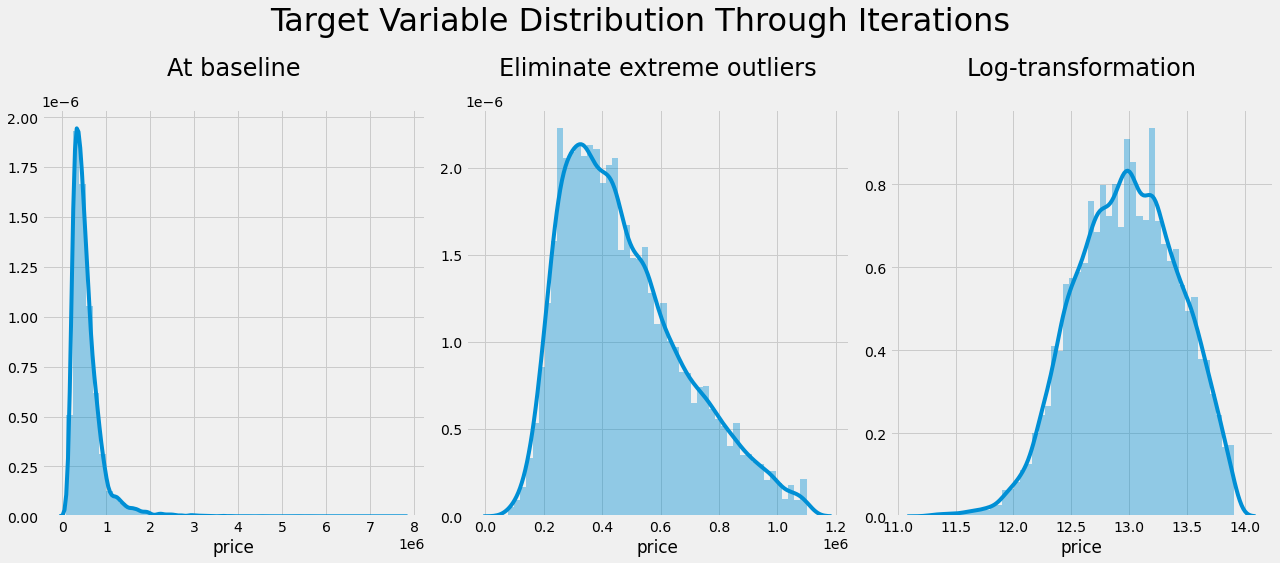

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

og = sns.distplot(data.price,ax=ax1).set_title('At baseline\n',fontsize=24)
ot = sns.distplot(y,ax=ax2).set_title('Eliminate extreme outliers\n',fontsize=24)
lo = sns.distplot(y_log,ax=ax3).set_title('Log-transformation\n',fontsize=24)

ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")


plt.gcf().set_size_inches(18, 8)
plt.suptitle("Target Variable Distribution Through Iterations",fontsize=32)
fig.tight_layout()
plt.show()


At this point the model was strong, the set of features was somewhat limited. The 'zipcode' feature also still remained and was essentially uninterpretable due to the fact that it is not only categorical but nominal in nature. The next succesfuly better iteration was to extrapolate the proximity of a particular waterfront from the zipcode feature, and then one-hot encoding each waterfront location. The details of how this was performed is outlined below. 

In [11]:
# Dictionary with zipcodes associated with waterfronts described by the data dictionary
water_loc_dict = {'Duwamish':[98168],
'Elliott Bay':[98119,98104,98129,98132,98127,98125,98195,98101,98134,98170,98139,98131,98181], 
'Puget Sound':[98071,98083,98013,98070,98031,98131,98063,98195,98207,98190], 
'Lake Union':[98109], 
'Ship Canal':[00000], 
'Lake Washington':[98072,98077], 
'Lake Sammamish':[98074,98075,98029], 
'other lake':[00000], 
'river/slough waterfronts':[00000]}

# list to contain new column data
waterfront_list = []

# for loop to assign waterfront based on zipcode
for zipcode in X_outliers_eliminatd.zipcode:
    for k,v in water_loc_dict.items():
        if zipcode in v:
            waterfront_list.append(k)
            appended = True
            break
        else: 
            appended = False
    if not appended:
        waterfront_list.append('NONE')

# for readibility and convenience create new dataframe inlcuding waterfront_loc feature
X_waters = X_outliers_eliminatd
X_waters['waterfront_loc'] = waterfront_list

# one-hot encoding waterfront_loc
waterfront_dummies = pd.get_dummies(X_waters.waterfront_loc,prefix='waterfront',prefix_sep='_').drop('waterfront_NONE',axis=1)
X_hot_waters = pd.concat([X_waters,waterfront_dummies],axis=1)

# zipcode has now be interpolated into waterfront_loc, waterfront_loc is now one-hot encoded and it is all string types
# so it is not able to be passed into the regression model 
X_hot_waters = X_hot_waters.drop(['zipcode','waterfront_loc'],axis=1) 

# Modeling
<a id='modeling'></a>

An extensive iterative process was conducted to achieve the final model, to see this process in detail please explore the notebook file 'EDA.ipynb' in this repository. 

The iterative process included the above described data engineering techniques, but also performing feature selecting and elimination before and after every dataframe manipulation using a stepwise forward-bacward selection (based on coefficient P value, community sourced function... see EDA notebook), recursive feature ranking and selection with cross validation based on coefficient strength (from scikit learn library, features selection module), elimination based on variance inflation factor.

To repeat this entire iterative process in this notebook would defeat the purpose of this notebook, so a list of column labels from the final model in the EDA journal is copy/pasted here in order to slice those particular columns from the dataframe prepared within this notebook. This should reproduce the same model as the final model in the EDA journal

In [12]:
feature_list = ['bathrooms','lat','grade','sqft_living15','view','condition','waterfront_Lake Washington','waterfront_Duwamish','sale_date','waterfront','waterfront_Lake Union','waterfront_Lake Sammamish','sale_month','waterfront_Puget Sound']
X = X_hot_waters[feature_list]

In [13]:
model = run_OLS_model(X,y_log)
residuals = model.resid

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     2944.
Date:                Sun, 17 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:24:00   Log-Likelihood:                -944.25
No. Observations:               19982   AIC:                             1919.
Df Residuals:                   19967   BIC:                             2037.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -173.1267     12.542    -13.804      0.000    -197.710    -148.543
bathrooms                      0.0864      0.003     26.243      0.000       0.080       0.093
lat                            1.4771      0.013    111.257      0.000       1.451       1.503
grade                          0.1527      0.003     58.332      0.000       0.148       0.158
sqft_living15                  0.0002   4.13e-06     39.495      0.000       0.000       0.000
view                           0.0734      0.003     24.402      0.000       0.068       0.079
condition                      0.0999      0.003     35.202      0.000       0.094       0.105
waterfront_Lake Washington    -0.2440      0.013    -19.292      0.000      -0.269      -0.219
waterfront_Duwamish           -0.2243      0.016    -14.064      0.000      -0.256      -0.193
sale_date                      0.0002    1.7e-05      9.108      0.000       0.000       0.000
waterfront                     0.3495      0.038      9.265      0.000       0.276       0.423
waterfront_Lake Union          0.3121      0.028     11.098      0.000       0.257       0.367
waterfront_Lake Sammamish      0.0366      0.008      4.318      0.000       0.020       0.053
sale_month                    -0.0025      0.001     -4.068      0.000      -0.004      -0.001
waterfront_Puget Sound        -0.0569      0.013     -4.243      0.000      -0.083      -0.031
==============================================================================
Omnibus:                      218.309   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              372.712
Skew:                           0.041   Prob(JB):                     1.17e-81
Kurtosis:                       3.664   Cond. No.                     5.14e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.14e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
# create a train and a test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2)

# generate predictions based on test and train sampels
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# calculate train and test residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [22]:
# calculate train and test mean squared error 
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squarred Error:', round(train_mse,3))
print('Test Mean Squarred Error:', round(test_mse,3))
print('Difference: ', round(abs(train_mse - test_mse),3))

Train Mean Squarred Error: 0.064
Test Mean Squarred Error: 0.065
Difference:  0.0


In [23]:
cv_5_results  = np.mean(cross_val_score(linreg, X, y_log, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X, y_log, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X, y_log, cv=20, scoring='neg_mean_squared_error'))

print('Five k-fold MSE: ', round(cv_5_results,3))
print('Ten k-fold MSE: ', round(cv_10_results,3))
print('Twenty k-fold MSE: ', round(cv_20_results,3))

Five k-fold MSE:  -0.064
Ten k-fold MSE:  -0.064
Twenty k-fold MSE:  -0.064


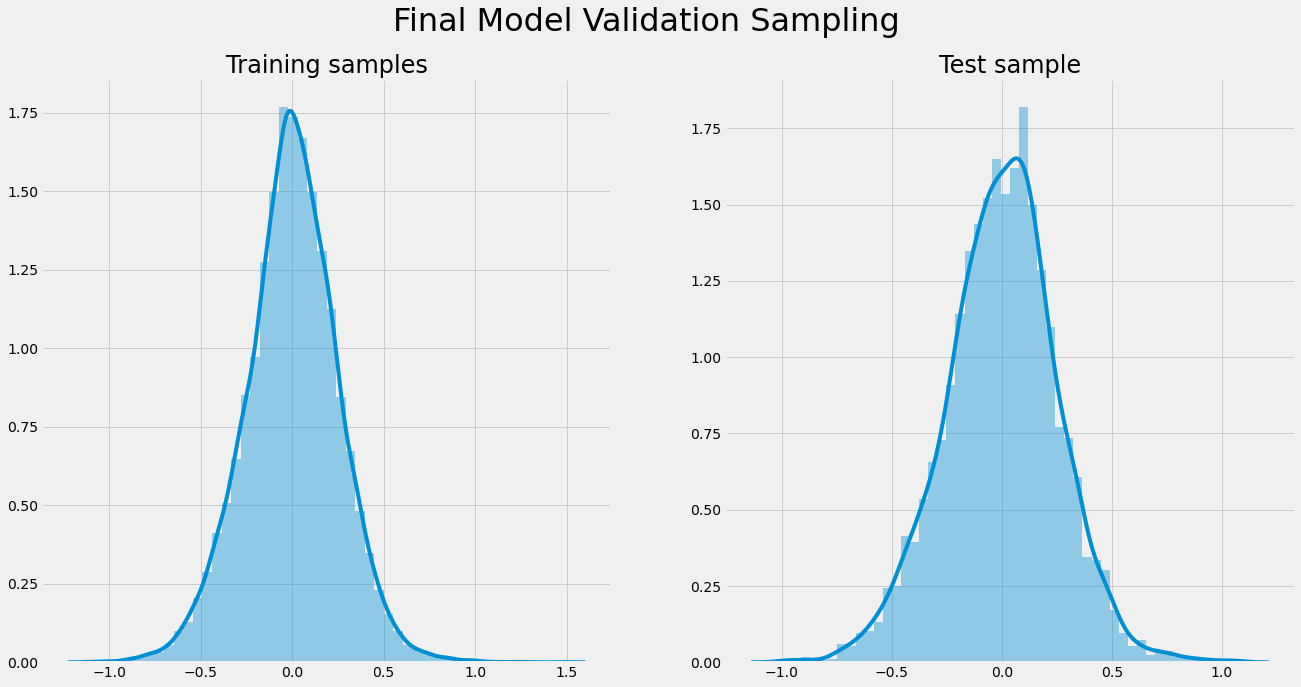

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.distplot(train_residuals,ax=ax1)
ax1.set_title('Training samples',fontsize=24)
ax1.set_ylabel('')
ax1.set_xlabel('')
sns.distplot(test_residuals,ax=ax2)
ax2.set_title('Test sample',fontsize=24)
ax2.set_ylabel('')
ax2.set_xlabel('')

fig.suptitle('Final Model Validation Sampling\n',fontsize=32)
plt.gcf().set_size_inches(20, 10)
plt.show()

The model above, as well as its mean-squared error, is identical to the final model decided on in the EDA notebook. This means that this model is in fact reproducable and not an artifact of some functional error within the notebook. 

# Regression Results
<a id='regression_results'><a>

In [25]:
# data series of features and their coefficients
coef_series = model.summary2().tables[1]['Coef.'][1:]

# above dataseries as a dictionary 
feature_effect_dict = {}
for item in coef_series.iteritems():
    feature_effect_dict[item[0]] = round(item[1],3)

Use this function below to see in plain language how each of the model feature affects price

In [26]:
def feature_impacts(dictionary=feature_effect_dict):

    feature_list = sorted(list(feature_effect_dict.keys()))

    print('Please select a feature from the following list...\n')

    for item in feature_list:
        print(item)

    user_input = input("")

    if user_input not in feature_list:
        print('\nPlease check spelling, and ensure your input is in the list provided.')
        
    effect = feature_effect_dict[user_input]

    if effect > 0 :
        print(f"\nFor every unit increase of {user_input}, the price of a property increases by {effect}%")
    else:
        print(f"\nFor every unit increase of {user_input}, the price of a property decrease by {effect}%")

In [28]:
# first uncomment the line below, press shift+enter, the type in the feature you are interested in exactly as it appears in the list that will be printed
# feature_impacts()

### My interpretation and summary of the model

I have confidence that this is a strong model because as best I can tell it satisfies the four assumptions of linear regression as best as it can with the data availble. 
- When plotted the model residuals show strong resemblence to the t-distribution satisfying the normality assumption, save only for slightly long tails. 
- The Drubin-Watson score is nearly 2.0 exactly, clearly demonstrating that the model satisfies the homoscedasticity assumption. 
- The linearit assumption is difficult to validate with a single model alone, but I have been incresingly convinced that this model satisfies the linearity assumption thorughout the development of this model. 
- The condition number is heavy which can be interpeted as an indaction of multi-colinearity. However there may be a scaling issue here, when the condion numebrs of each iteration of the model from the baseline up to the one in this notebook are plotted, the condition number of this model is 0 relative to its prototypical counterparts. Likewise for the Jarque Bera, and indication of normality. 
- The kurtosis of this model is slightly outside the normally accepted range, throught the iterative process any attempts to address this issue drasticaly worsened all other indicators of model strenght. Additionally and kurtosis of 3.664 is the lowest of any iteration of the model so I have to run with it. 

The intention of this analysis to help Fliphouse, LLC. understand where to purchase properties as well as what physical aspects of the properties to consider before buying. 

In regard to where to purchase properties, the latitude that a property lies on seems to be the strongest predictor of price. For every addition degree north, a properties price will increase by 1.47%. However the properties in this data set cover a range less than 1 degree. One degree of latittude is roughly 69 miles, and the range covered by the model data is only abouty 43 miles. So we can consider this to mean that aproximately for every additional mile north, the price of a property increases by 0.034%

Wether or not a property lies on a waterfront is a strong predictor as well, if it in fact does the price increases by 0.35%. Additionally if a property is even in the same zipcode as Lake Union the price of the property will increase by 0.31%. However property prices decrease if the proeprty is in the same zipcodes as Lake Washington, Duwamish, or Puget Sound.

In regard to what physical aspects of a property to consider, grade is the strongest predictor of price. Grade is on a scale of 1-11 and indicates how well the property satsifies the building codes as well as the quality and level of luxury of the property; for every additional point on the 1-11 scale the price of a property increases by 0.15% meaning that rufurbishing a home that is not even up to code into a luxury home could increase the price by more than an entire percentage point.

Condition is another strong predictor and is similar to grade, it is a more qualitative version and does not refer to its satisfaction of building codes, it is on a scale of 1-5 and according to the model for every additional point here the price of the property will increase by 0.1%. 

View is worth considering as well, the quality of the view from a property is also on a scale of 1-5 and for every additional point the price of a property increases by 0.07%. It is also worth noting that the price of a property increases by 0.09% for every additional bathroom in the house.

When is the best time to by is somewhat unclear. The model suggests that prices decrease slightly month-to-month if you begin in January (i.e. sale_month, -0.0025). However prices tend to increase the more recent the sale was (i.e. sale_date, 0.0002). Considering that the dataset covers a range of dates from May 02, 2104 to May 24, 2015, my intuition is that spring/early summer is the when prices are highest, but I'm not confident that I can empirically support that claim with this model. 

# Conclusion
<a id='conlusion'><a>

For the purposes of Fliphouse, LLC penetrating the King County realestate market. I recommend looking at properties on Lake Union, or north of downtown Seattle that are also on a waterfront, preferably with a view of said waterfront. Furthermore I recommend finding properties that satisfty the aformentioned geogrpahic stipulations that are in need of repair and potentially do not satisfy city building codes. The best course of action according to this analysis would be to bring the building and property up to code and beyond and additionally perhaps add one or two bathrooms to the home (perhaps an outdoor shower near the waterfront access). 

In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     2944.
Date:                Sun, 17 Apr 2022   Prob (F-statistic):               0.00
Time:                        16:19:37   Log-Likelihood:                -944.25
No. Observations:               19982   AIC:                             1919.
Df Residuals:                   19967   BIC:                             2037.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -173.1267     12.542    -13.804      0.000    -197.710    -148.543
bathrooms                      0.0864      0.003     26.243      0.000       0.080       0.093
lat                            1.4771      0.013    111.257      0.000       1.451       1.503
grade                          0.1527      0.003     58.332      0.000       0.148       0.158
sqft_living15                  0.0002   4.13e-06     39.495      0.000       0.000       0.000
view                           0.0734      0.003     24.402      0.000       0.068       0.079
condition                      0.0999      0.003     35.202      0.000       0.094       0.105
waterfront_Lake Washington    -0.2440      0.013    -19.292      0.000      -0.269      -0.219
waterfront_Duwamish           -0.2243      0.016    -14.064      0.000      -0.256      -0.193
sale_date                      0.0002    1.7e-05      9.108      0.000       0.000       0.000
waterfront                     0.3495      0.038      9.265      0.000       0.276       0.423
waterfront_Lake Union          0.3121      0.028     11.098      0.000       0.257       0.367
waterfront_Lake Sammamish      0.0366      0.008      4.318      0.000       0.020       0.053
sale_month                    -0.0025      0.001     -4.068      0.000      -0.004      -0.001
waterfront_Puget Sound        -0.0569      0.013     -4.243      0.000      -0.083      -0.031
==============================================================================
Omnibus:                      218.309   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              372.712
Skew:                           0.041   Prob(JB):                     1.17e-81
Kurtosis:                       3.664   Cond. No.                     5.14e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.14e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Next steps

It is worth one-hot encoding some of the other categorical features such as view and grade. Also, investigating eliminating outliers based on category (e.g. there are only 27 data points with a grade of 4, and only 1 with a grade of 3 or less.). Some of the leptokurtosis may be address by continuing to eliminate outliers using this method. 

This dataset covers a timespan of roughly one year, it would certainly strengthen the model to include analogous data from other years both before and after. 


# Visualiztions

Some visualizations for presentation purposes meant to hint at how well the model can answer various questions they would likely like to ask.

In [27]:
coef_series = coef_series.sort_values(ascending=False)

quest_dict = {
'How far north?':coef_series['lat'],
'On a waterfront?':coef_series['waterfront'],
'Which waterfront?':sum(abs(coef_series[['waterfront_Lake Union','waterfront_Lake Sammamish','waterfront_Puget Sound','waterfront_Duwamish','waterfront_Lake Washington']])),
'How much repair needed?':sum(abs(coef_series[['condition','grade']])),
'How many bathrooms?':coef_series['bathrooms'],
'Good view?':coef_series['view'],
'When?':sum(abs(coef_series[['sale_date','sale_month']]))
}

quest_dict

{'How far north?': 1.4770811449849992,
 'On a waterfront?': 0.34949918084450954,
 'Which waterfront?': 0.8739535489846464,
 'How much repair needed?': 0.25260992113104447,
 'How many bathrooms?': 0.08639102479362598,
 'Good view?': 0.07343130156894614,
 'When?': 0.0026533397723983573}

In [28]:
minima = min(quest_dict.values())
maxima = max(quest_dict.values())

norm = cm.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.YlGnBu)
color_map =[]

for k,v in quest_dict.items():
    color_map.append(mapper.to_rgba(v))

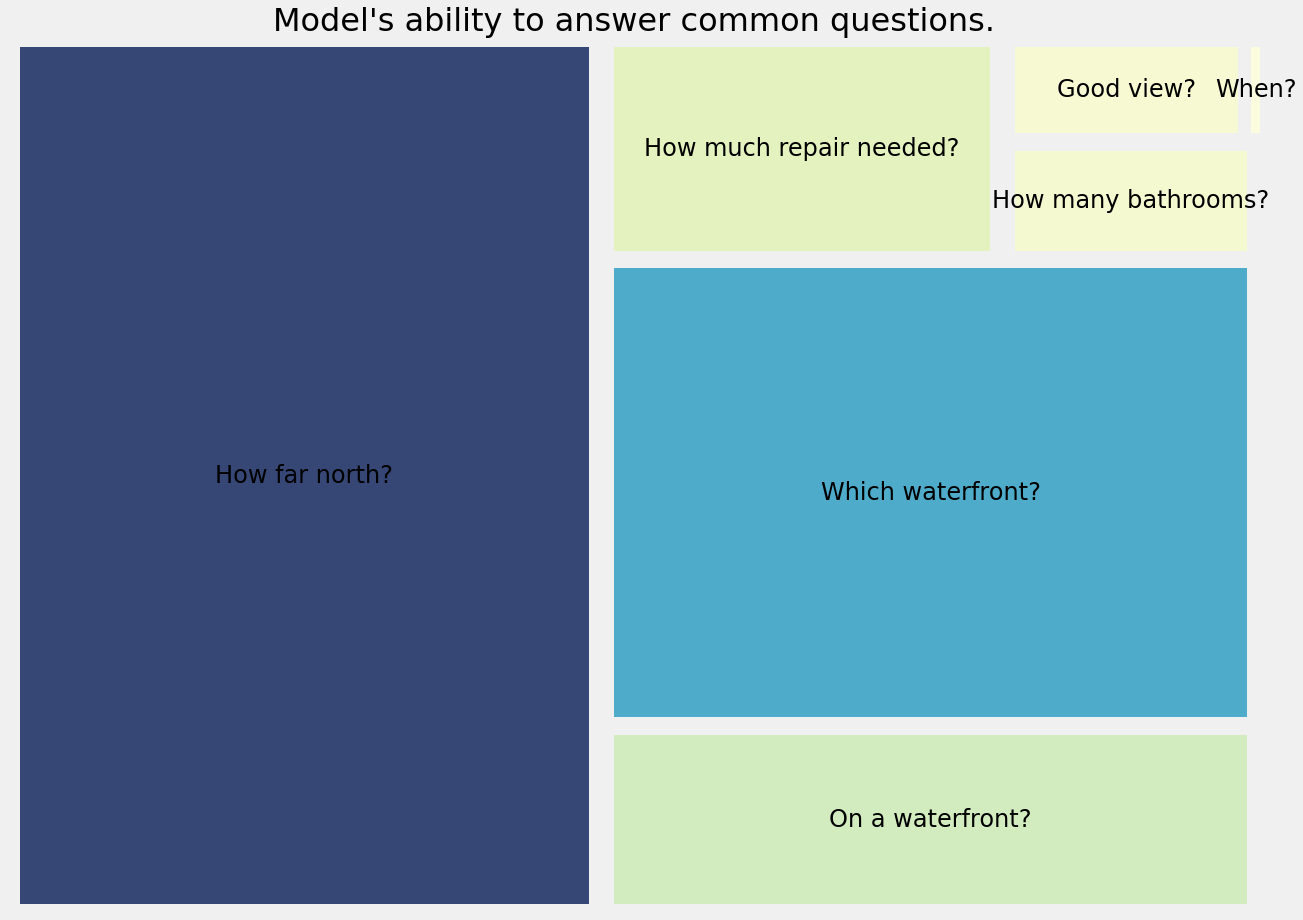

In [29]:

squarify.plot(sizes=quest_dict.values(), label=quest_dict.keys(), 
              alpha=.8,text_kwargs={'fontsize':24},color=color_map,pad=.002).set_title("Model's ability to answer common questions.",fontsize=32)

plt.gcf().set_size_inches(20, 15)
plt.axis('off')
plt.show()

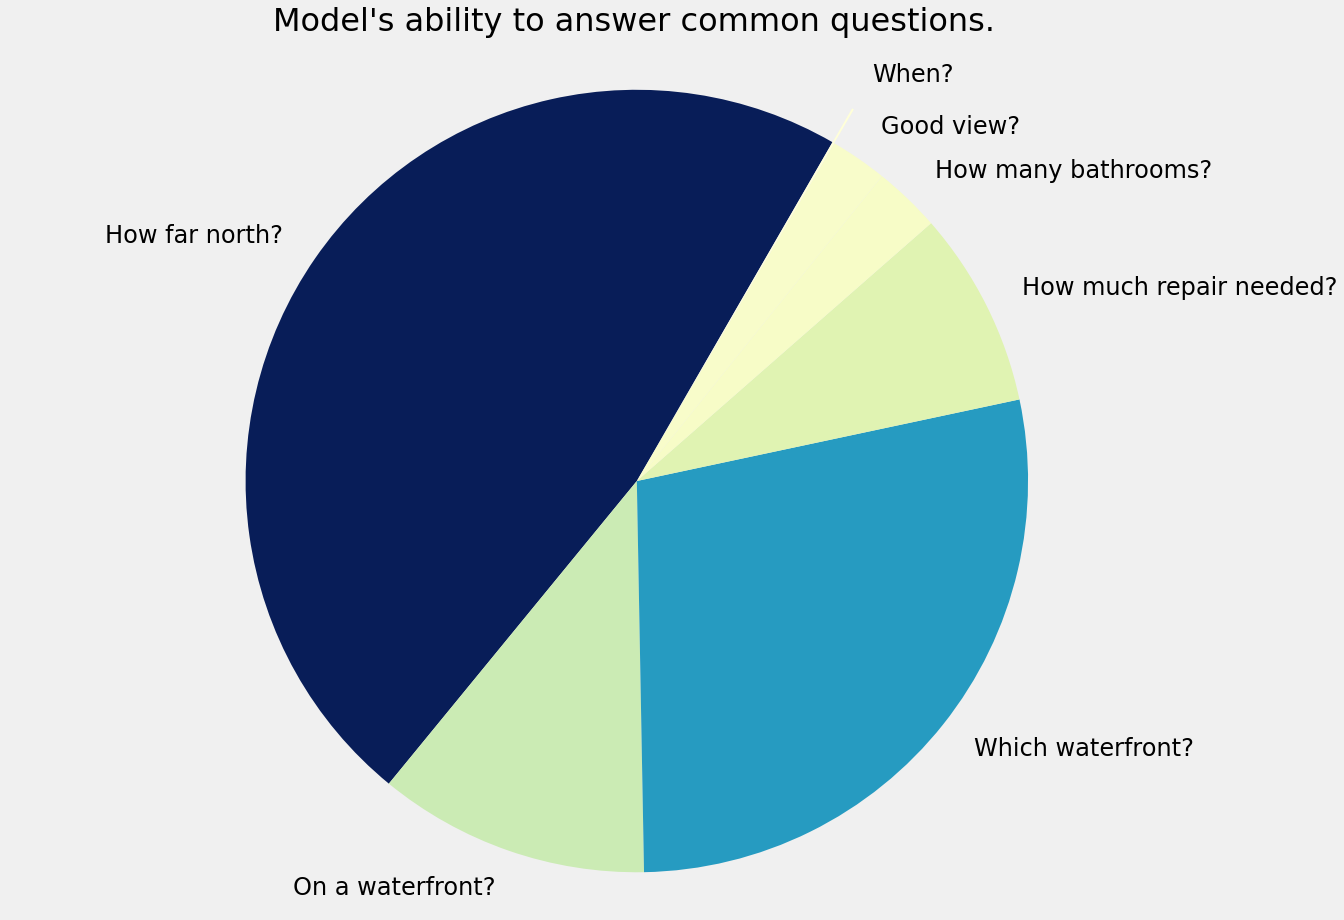

In [48]:
fig, ax = plt.subplots()

explode = (0, 0, 0, 0, 0, 0, 0.1)

ax.pie(quest_dict.values(),labels=quest_dict.keys(),explode=explode,startangle=60,colors=color_map,textprops={'fontsize':24})
ax.set_title("Model's ability to answer common questions.",fontsize=32)
ax.axis('equal')

plt.gcf().set_size_inches(20, 15)
plt.show()

For additional info, contact Zeth Abney at [zethusabney@gmail.com](mailto:zethusabney@gmail.com)